In [1]:
!pip install tensorflow-gpu==1.13.1

In [2]:
import tensorflow as tf
import numpy as np

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


# Problem 1 (10 pts)

**CIFAR10 클래스가 다음과 같은 기능을 갖도록 코드를 작성하시오.**


-get_train_batch 함수로 batch_size 만큼의 학습데이터를 return한다.

-get_test_batch 함수로 Validation or Test 데이터를 return한다.
*   is_val=True 이면 Validation 데이터를, False이면 Test데이터를 return한다.
*   split_num개만큼 데이터를 split하여 list 형태로 return한다. ex) Data : numpy array [1,2,3,4,5,6], split_num : 2, -> return : [[1,2,3], [4,5,6]]

-epochs와 iterations 변수를 통해 현재 epoch과 iteration 정보를 얻을 수 있다.
*   ex) cifar10 = CIFAR10(), print(cifar10.epochs) -> 20

-reset 함수를 통해 epoch과 iteration 정보를 초기화 시킨다. (새로운 모델에 처음부터 다시 학습을 시작할 때 사용)

In [0]:
class CIFAR10:
  def __init__(self):
    self.X_train = np.load("/gdrive/My Drive/숙제4/CIFAR10_datasets/CIFAR10_X_train.npy")
    self.Y_train = np.load("/gdrive/My Drive/숙제4/CIFAR10_datasets/CIFAR10_y_train.npy")
    self.X_test = np.load("/gdrive/My Drive/숙제4/CIFAR10_datasets/CIFAR10_X_test.npy")
    self.Y_test = np.load("/gdrive/My Drive/숙제4/CIFAR10_datasets/CIFAR10_y_test.npy")

    self.X_val = self.X_train[45000:]
    self.Y_val = self.Y_train[45000:]
    self.X_train = self.X_train[:45000]
    self.Y_train = self.Y_train[:45000]

    self.idx_flag = 0
    self.epochs = 0
    self.iterations = 0

  def get_train_batch(self, batch_size=64):
    X_batch, Y_batch = None, None,
    ####################### Put your code here ###############    
    if self.X_train.shape[0] <= self.idx_flag:
        self.iterations = 0
        self.epochs += 1
        self.idx_flag = 0
        idx = np.arange(self.X_train.shape[0])
        np.random.shuffle(idx)
        self.X_train = self.X_train[idx]
        self.Y_train = self.Y_train[idx]

    end = min(self.X_train.shape[0], self.idx_flag + batch_size)
    X_batch = self.X_train[self.idx_flag:end]
    Y_batch = self.Y_train[self.idx_flag:end]
    self.iterations += 1
    self.idx_flag += batch_size
    ##########################################################
    return X_batch, Y_batch

  def get_test_batch(self, is_val=True, split_num=100):
    split_X, split_Y = None, None
    ####################### Put your code here ###############
    if is_val:
        split_X = np.split(self.X_val, split_num)
        split_Y = np.split(self.Y_val, split_num)
    else:
        split_X = np.split(self.X_test, split_num)
        split_Y = np.split(self.Y_test, split_num)
    ##########################################################
    return split_X, split_Y
  
  def reset(self):
    ####################### Put your code here ###############
    self.epochs = 0
    self.iterations = 0
    self.idx_flag = 0
    ##########################################################

# Problem 2 (20 pts)
**tensorflow 라이브러리를 이용하여 다음 함수들을 작성하시오.**

In [0]:
def conv_layer(input, output_channel, filter_size=2, stride=1, padding='same', use_bias=True):
    output = None
    ####################### Put your code here ###############
    input_channel = input.get_shape().as_list()[-1]
    weight = tf.Variable(tf.random_normal([filter_size, filter_size, input_channel, output_channel], stddev=0.01))
    output = tf.nn.conv2d(input, weight, strides=[stride, stride, stride, stride], padding=padding.upper())
    if use_bias:
        bias = tf.Variable(tf.constant(0.1, shape=[output_channel]))
        output = output + bias
    ##########################################################
    return output

def fc_layer(input, output_size, use_bias=True):
    output = None
    ####################### Put your code here ###############
    shape = input.get_shape().as_list()
    weight = tf.Variable(tf.random_normal([shape[-1], output_size], stddev=0.01))
    bias= tf.Variable(tf.constant(0.1, shape=[output_size]))
    output = tf.matmul(input, weight) + bias
    ##########################################################
    return output

def squeeze_excitation_block(input, ratio=16):
    output = None
    ####################### Put your code here ###############
    out_channels = input.get_shape().as_list()[-1]
    squeeze = global_average_pooling(input)
    excitation = fc_layer(squeeze, output_size= int(out_channels/ratio))
    excitation = relu(excitation)
    excitation = fc_layer(excitation, output_size=out_channels)
    scales = sigmoid(excitation)
    
    scales = tf.reshape(excitation, [-1,1,1,out_channels])
    output = tf.math.multiply(input, scales)
    ##########################################################
    return output

def relu(input):
    output = None
    ####################### Put your code here ###############
    output = tf.nn.relu(input)
    ##########################################################
    return output

def sigmoid(input):
    output = None
    ####################### Put your code here ###############
    output = tf.nn.sigmoid(input)
    ##########################################################
    return output

def global_average_pooling(input):
    output = None
    ####################### Put your code here ###############
    output = tf.reduce_mean(input, axis=[1,2])
    ##########################################################
    return output

def max_pooling(input, filter_size=2, stride=2, padding="same"):
    output = None
    ####################### Put your code here ###############
    output = tf.nn.max_pool(input, ksize=[1, filter_size, filter_size, 1], strides=[1, stride, stride, 1], padding=padding.upper())
    ##########################################################
    return output
  
def flatten_block(input):
    output = None
    ####################### Put your code here ###############
    shape = input.get_shape().as_list()
    output = tf.reshape(input, [-1, shape[1] * shape[2] * shape[3]])
    ##########################################################
    return output

def batch_norm(input, is_training):
    output = None
    ####################### Put your code here ###############
    output = tf.layers.batch_normalization(input, center=True, scale=True, training=is_training)
    ##########################################################
    return output

# Problem 3 (20 pts)

Problem 2에서 작성한 함수들을 이용하여 다음 조건을 만족하는 CNN 모델을 작성하시오.
*   Validation accuracy가 70% 이상인 네트워크.
*   use_SE=True이면 Squeeze and Excitation block이 추가된 모델을, False이면 추가되지 않은 모델을 return.
*   두개의 모델은 SE block의 유무를 제외한 모든 세팅이 같아야함. (하이퍼 파라미터, SE block 이외의 layer 구조 등)

In [0]:
def cnn_model(X, Y, is_training, use_SE=True):
    loss, accuracy, backprop = None, None, None
    ####################### Put your code here ###############
    out = conv_layer(X, output_channel=64, filter_size=3)
    out = relu(out)
    out = max_pooling(out)

    out = conv_layer(out, output_channel=64, filter_size=3)
    out = relu(out)
    out = max_pooling(out)
    out = tf.nn.dropout(out, 0.3)

    out = conv_layer(out, output_channel=128, filter_size=3)
    out = relu(out)
    
    out = conv_layer(out, output_channel=128, filter_size=3)
    out = relu(out)

    if use_SE:
        out = squeeze_excitation_block(out)

    out = conv_layer(out, output_channel=128, filter_size=3)
    out = relu(out)
    out = tf.nn.dropout(out, 0.3)

    out = flatten_block(out)
    logits = fc_layer(out, output_size=10)
    
    # labels = tf.cast(tf.squeeze(tf.one_hot(Y, depth=10, axis=-1)), tf.int32)

    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=Y)
    loss = tf.reduce_mean(ce)

    backprop = tf.train.AdamOptimizer(0.0002).minimize(loss)

    correctness = tf.equal(tf.argmax(logits,1), Y)
    accuracy = tf.reduce_mean(tf.cast(correctness, tf.float32))

    ##########################################################
    return loss, accuracy, backprop

# Problem 4 (20 pts)

Problem 3에서 작성된 모델을 학습하고 테스트 하는 함수를 작성하여라.

In [0]:
def train_model(sess, cifar10, X, Y, is_training, loss, accuracy, backprop, epochs=10, batch_size=32, check_iter=100, split_num=100):
    train_loss_list, validation_loss_list, train_acc_list, validation_acc_list = [], [], [], []
    while cifar10.epochs < epochs:
        l, acc = None, None
        ####################### Put your code here ###############
        X_batch, Y_batch = cifar10.get_train_batch(batch_size=batch_size)
        x_batch = X_batch / 255.0

        train_dict = {
            X: x_batch,
            Y: Y_batch,
            is_training: True
        }

        _, l, acc = sess.run([backprop, loss, accuracy], feed_dict=train_dict)
        
        ##########################################################
        if cifar10.iterations%check_iter == 0:
            val_loss, val_acc = test_model(sess, cifar10, X, Y, is_training, loss, accuracy, split_num, is_val=True)
            print('Epochs : %d, Iterations : %d, Train_loss : %f, Train_accuracy : %.3f, Val_loss : %f, Val_accuracy : %.3f'%\
                    (cifar10.epochs, cifar10.iterations, l, acc, val_loss, val_acc))
            train_loss_list.append(l)
            validation_loss_list.append(val_loss)
            train_acc_list.append(acc)
            validation_acc_list.append(val_acc)

    return train_loss_list, validation_loss_list, train_acc_list, validation_acc_list

def test_model(sess, cifar10, X, Y, is_training, loss, accuracy, split_num, is_val):
    X_list, Y_list = cifar10.get_test_batch(is_val=is_val, split_num=split_num)
    accs, losses = None, None
    ####################### Put your code here ###############
    accs = 0
    losses = 0
    ##########################################################
    for X_batch, Y_batch in zip(X_list, Y_list):
        ####################### Put your code here ###############
        x_batch = X_batch / 255.0

        test_dict = {
            X: x_batch,
            Y: Y_batch,
            is_training:False
        }
        l, acc = sess.run([loss, accuracy], feed_dict=test_dict)

        accs += acc
        losses += l
        ##########################################################
    ####################### Put your code here ###############
    accs /= split_num
    losses /= split_num
    ##########################################################
    return losses, accs

# Problem 5 (20 pts)

SE block이 없는 CNN 모델과, SE block이 추가된 CNN 모델을 각각 학습하시오. (단, 아래의 조건을 만족하여야 함)
*   둘중 적어도 하나의 모델은 Validation accuracy 70% 이상. (도달하지 못한다면 모델을 Problem 3의 모델을 수정하시오)
*   두개의 모델은 SE block의 유무를 제외한 모든 세팅이 같아야함. (하이퍼 파라미터, SE block 이외의 layer 구조 등)

# CNN training and test without Squeeze and Excitation block

In [8]:
cifar10 = CIFAR10()

X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
Y = tf.placeholder(dtype=tf.int64, shape=[None])
is_training = tf.placeholder(tf.bool)

loss, accuracy, backprop = cnn_model(X, Y, is_training, use_SE=False)

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  result_without_SE = train_model(sess, cifar10, X, Y, is_training, loss, accuracy, backprop, epochs=100, check_iter=300, batch_size=128)
  test_loss, test_acc = test_model(sess, cifar10, X, Y, is_training, loss, accuracy, split_num=100, is_val=False)
  print("Test_loss : %f, Test_accuracy : %.3f"%(test_loss, test_acc))

sess.close()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epochs : 0, Iterations : 300, Train_loss : 2.070217, Train_accuracy : 0.266, Val_loss : 2.050731, Val_accuracy : 0.238
Epochs : 1, Iterations : 300, Train_loss : 1.808862, Train_accuracy : 0.320, Val_loss : 1.722569, Val_accuracy : 0.364
Epochs : 2, Iterations : 300, Train_loss : 1.494624, Train_accuracy : 0.445, Val_loss : 1.585911, Val_accuracy : 0.416
Epochs : 3, Iterations : 300, Train_loss : 1.533889, Train_accuracy : 0.422, Val_loss : 1.528884, Val_accuracy : 0.451
Epochs : 4, Iterations : 300, Train_loss : 1.523402, Train_accuracy : 0.469, Val_loss : 1.487029, Val_accuracy : 0.461
Epochs : 5, Iterations : 300, Train_loss : 1.674802, Train_accuracy : 0.422, Val_loss : 1.418244, Val_accuracy : 0.488
Epochs : 6, Iterations : 300, Train_loss : 1.464693, Train_accuracy : 0.461, Val_loss : 1.388405, V

# CNN training and test with Squeeze and Excitation block

In [9]:
cifar10.reset()
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
Y = tf.placeholder(dtype=tf.int64, shape=[None])
is_training = tf.placeholder(tf.bool)

loss, accuracy, backprop = cnn_model(X, Y, is_training, use_SE=True)

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  result_with_SE = train_model(sess, cifar10, X, Y, is_training, loss, accuracy, backprop, epochs=100, check_iter=300, batch_size=128)
  test_loss, test_acc = test_model(sess, cifar10, X, Y, is_training, loss, accuracy, split_num=100, is_val=False)
  print("Test_loss : %f, Test_accuracy : %.3f"%(test_loss, test_acc))

sess.close()

Instructions for updating:
Use tf.cast instead.
Epochs : 0, Iterations : 300, Train_loss : 2.130176, Train_accuracy : 0.195, Val_loss : 2.104184, Val_accuracy : 0.207
Epochs : 1, Iterations : 300, Train_loss : 1.880198, Train_accuracy : 0.344, Val_loss : 1.875947, Val_accuracy : 0.305
Epochs : 2, Iterations : 300, Train_loss : 1.570427, Train_accuracy : 0.430, Val_loss : 1.704354, Val_accuracy : 0.382
Epochs : 3, Iterations : 300, Train_loss : 1.493450, Train_accuracy : 0.430, Val_loss : 1.594641, Val_accuracy : 0.424
Epochs : 4, Iterations : 300, Train_loss : 1.550565, Train_accuracy : 0.453, Val_loss : 1.520704, Val_accuracy : 0.442
Epochs : 5, Iterations : 300, Train_loss : 1.542883, Train_accuracy : 0.453, Val_loss : 1.481490, Val_accuracy : 0.464
Epochs : 6, Iterations : 300, Train_loss : 1.486154, Train_accuracy : 0.477, Val_loss : 1.451220, Val_accuracy : 0.475
Epochs : 7, Iterations : 300, Train_loss : 1.389396, Train_accuracy : 0.469, Val_loss : 1.415093, Val_accuracy : 0.479


# Problem 6 (10 pts)

matplotlib와 result_with_SE, result_without_SE 를 이용하여 다음 learning curve들을 plot 하시오. (여러개의 cell을 사용하여도 무방)

*   SE 사용 네트워크와 SE 미사용 네트워크의 training loss
*   SE 사용 네트워크와 SE 미사용 네트워크의 validation loss
*   SE 사용 네트워크와 SE 미사용 네트워크의 validation accuracy
*   SE 사용 네트워크의 training loss와 validation loss
*   SE 사용 네트워크의 training accuracy와 validation accuracy
*   SE 미사용 네트워크의 training loss와 validation loss
*   SE 미사용 네트워크의 training accuracy와 validation accuracy



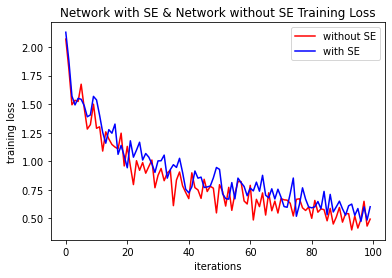

In [10]:
import matplotlib.pyplot as plt

train_loss_list, validation_loss_list, train_acc_list, validation_acc_list = result_without_SE

SE_train_loss_list, SE_validation_loss_list, SE_train_acc_list, SE_validation_acc_list = result_with_SE

plt.plot(train_loss_list, color='red', label='without SE')
plt.plot(SE_train_loss_list, color='blue', label='with SE')

plt.legend()
plt.xlabel('iterations')
plt.ylabel('training loss')
plt.title('Network with SE & Network without SE Training Loss')
plt.show()

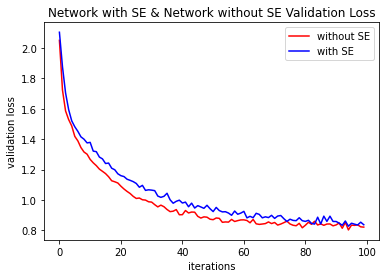

In [11]:
plt.plot(validation_loss_list, color='red', label='without SE')
plt.plot(SE_validation_loss_list, color='blue', label='with SE')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('validation loss')
plt.title('Network with SE & Network without SE Validation Loss')
plt.show()

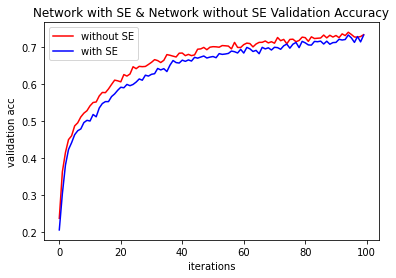

In [12]:
plt.plot(validation_acc_list, color='red', label='without SE')
plt.plot(SE_validation_acc_list, color='blue', label='with SE')

plt.legend()
plt.xlabel('iterations')
plt.ylabel('validation acc')
plt.title('Network with SE & Network without SE Validation Accuracy')
plt.show()

Text(0.5, 1.0, 'Training Loss and Validation Loss of Network with SE')

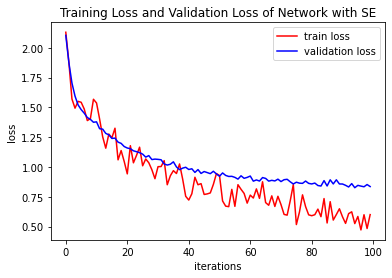

In [13]:
plt.plot(SE_train_loss_list, color='red', label='train loss')
plt.plot(SE_validation_loss_list, color='blue', label='validation loss')

plt.legend()
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Training Loss and Validation Loss of Network with SE')

Text(0.5, 1.0, 'Training Acc and Validation Acc of Network with SE')

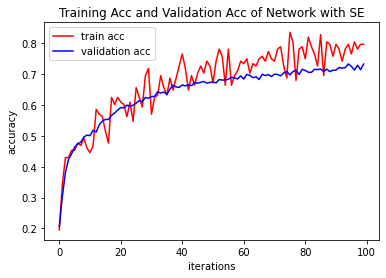

In [14]:
plt.plot(SE_train_acc_list, color='red', label='train acc')
plt.plot(SE_validation_acc_list, color='blue', label='validation acc')

plt.legend()
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Training Acc and Validation Acc of Network with SE')

Text(0.5, 1.0, 'Training Loss and Validation Loss of Network without SE')

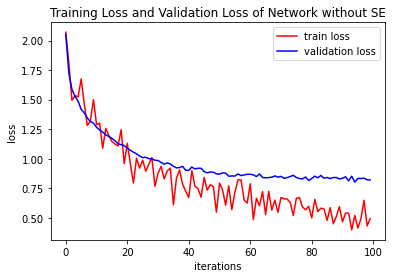

In [15]:
plt.plot(train_loss_list, color='red', label='train loss')
plt.plot(validation_loss_list, color='blue', label='validation loss')

plt.legend()
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Training Loss and Validation Loss of Network without SE')

Text(0.5, 1.0, 'Training Accuracy and Validation Accuracy of Network without SE')

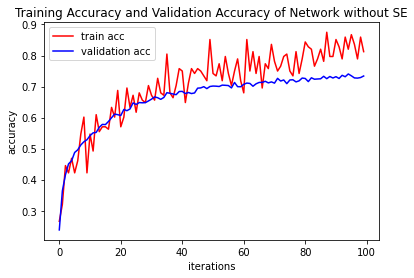

In [16]:
plt.plot(train_acc_list, color='red', label='train acc')
plt.plot(validation_acc_list, color='blue', label='validation acc')

plt.legend()
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Training Accuracy and Validation Accuracy of Network without SE')